# FinnSentiment

Neural Network implementation of sentiment analysis using **FinnSentiment** dataset from https://github.com/cynarr/sentiment-analysis/tree/master/data-raw

## 1. Binary Classifier
In this section, we will consider only 2 polarities of the comments: **positive** and **negative**.


In [1]:
# uncomment to install packages
'''
%pip install numpy
%pip install matplotlib
%pip install nltk
'''

'\n%pip install numpy\n%pip install matplotlib\n%pip install nltk\n'

In [2]:
#import essential packages for the project
import numpy as np
import matplotlib.pyplot as plt

from string import punctuation

import nltk
from nltk.tokenize import word_tokenize

%matplotlib inline
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
print('\nPunctuation\n')
print(punctuation)


Punctuation

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [4]:
# example of how to use word_tokenize
word_tokenize('I am a girl.')

['I', 'am', 'a', 'girl', '.']

### 1.1 data preprocessing

In [5]:
# function to read data from a file
def process_data(datatype, language, label):
    '''
        input:
            - datatype: 'train' or 'test'
            - language: 'en'(English) or 'fi'(Finnish)
            - label: 'pos'(positive) or 'neg'(negative)
        output:
            - list of sentences
    '''
    filename = label + '_test.txt' if datatype=='test' else label + '.txt'
    filepath = 'data-raw/bin/' + language + '/' + datatype + '/' + filename

    with open(filepath, mode='r', encoding='utf8') as f:
        sentences = f.readlines()

    # -------------------------------------------------- data preprocessing  -------------------------------------------------- #
    data = []
    
    for sentence in sentences:
        sentence = sentence.lower() # lowercase
        sentence = sentence.replace('\n','') # remove \n  

        words = word_tokenize(sentence) # tokenisation
        # remove non-alphabet characters and punctuations
        for word in words:
            if (word in list(punctuation)) or word.isalpha()==False: 
                words.remove(word)
                
        # append list of words of a sentence to data
        data.append(words)
    # -------------------------------------------------- data preprocessing  -------------------------------------------------- #

    pol = 1 if label == 'pos' else 0 #polarity
    data = [(sentence, pol) for sentence in data]
    return data


In [6]:
# data preprocessing: get list of words for each sentence
train_pos = process_data('train','fi','pos')
train_neg = process_data('train','fi','neg')
test_pos = process_data('test','fi','pos')
test_neg = process_data('test','fi','neg')

print('preprocessing successful!')

preprocessing successful!


In [7]:
train = train_pos + train_neg
test = test_pos + test_neg

len(train), len(test)

(5774, 653)

In [8]:
# shuffle the data to reduce bias
import random

random.seed(10)
random.shuffle(train)
random.shuffle(test)

In [9]:
#validation set
split = int(0.9*len(train))
validate = train[split::]
train = train[0:split]
len(train), len(validate)

(5196, 578)

In [10]:
# separate sentences and polarity
def separate(all_list):
    train_sentences = [e[0] for e in all_list]
    train_pols = [e[1] for e in all_list]
    return train_sentences, train_pols


train_sentences, train_pols = separate(train)
val_sentences, val_pols = separate(validate)
test_sentences, test_pols = separate(test)

In [11]:
all_sentences = train_sentences + val_sentences + test_sentences
all_pols= train_pols + val_pols + test_pols

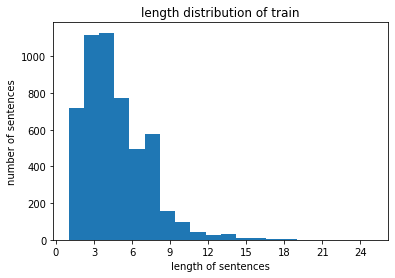

In [12]:
# sentence length distribution
rev_len = [len(i) for i in train_sentences]

plt.title('length distribution of train')
plt.hist(rev_len, bins=20)
plt.xlabel('length of sentences')
plt.ylabel('number of sentences')
plt.xticks(np.arange(0, 25, step=3))

plt.show()

In [13]:
from collections import Counter

corpus = sum(all_sentences, [])
counter_corpus = Counter(corpus)
num_vocab = len(counter_corpus.values())

In [14]:
max_len = max([len(sentence) for sentence in train_sentences])
print('the longest sentence has', max_len, 'words')

the longest sentence has 25 words


In [15]:
# word-to-index
corpus_set = list(set(corpus))
word2idx = {e: i+2 for i,e in enumerate(corpus_set)}

padded_text = '[PAD]'
word2idx[padded_text] = 0
unknown_text = '[UNK]'
word2idx[unknown_text] = 1

In [16]:
# index-to-word
idx2word = dict((v,k) for k,v in word2idx.items())

In [17]:
def one_hot_encoder(sentences):
    '''
    input:
        - list of sentences
    output:
        - list of encoded sentences (tt)
    '''
    tt = []
    for sentence in sentences:
        new = []
        for word in sentence:
            new.append(word2idx[word])
        if len(new) < max_len:
            for _ in range(0, max_len - len(new)):
                new.append(word2idx[padded_text])
        tt.append(new)
    return tt

In [18]:
train_sentences_enc = one_hot_encoder(train_sentences)

In [19]:
max_len = max([len(sentence) for sentence in train_sentences_enc])

# padding
def padding(data, pad, max_length):
    '''
    input:
        - data in sentence
        - pad: value to pad
        - max_length: maximum length of the sentence
    output:
        - padded data
    '''
    padded_data = data
    if len(padded_data) < max_length:
        for _ in range(0, max_length - len(padded_data)):
            padded_data.append(pad)
    return padded_data

train_sentences_enc = [padding(sen, -1, max_len) for sen in train_sentences_enc]

print('size of train_sentences_enc: ')
print(len(train_sentences_enc), len(train_sentences_enc[0]))

size of train_sentences_enc: 
5196 25


### 1.2 introduce PyTorch

In [20]:
# uncomment to install pytorch
'''
%pip install torch
'''

'\n%pip install torch\n'

In [21]:
# hello pytorch!!
import torch

data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

print('PyTorch run successfully!' if type(x_data) == torch.Tensor else 'FAILED!')

PyTorch run successfully!


### 1.3 word embedding

In [22]:
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F

In [23]:
embedding_dim = 5

embedding = nn.Embedding(num_vocab+2, embedding_dim)

train_shape = (len(train_sentences_enc), max_len, embedding_dim)
train_tensor = tensor(np.zeros(train_shape, dtype='float32'))

for i, sen_enc in enumerate(train_sentences_enc):
    for j, word_enc in enumerate(sen_enc):
        train_tensor[i][j] = embedding(tensor(word_enc))


In [24]:
train_tensor.size()

torch.Size([5196, 25, 5])

### 1.4 convolutional neural network (CNN)

In this project, we will use convolutional neural network (CNN) for the sentiment classification.

In [25]:
##hyper parameters
batch_size = 32
embedding_dims = 300 #Length of the token vectors
filters = 250 #number of filters in your Convnet
kernel_size = 3 # a window size of 3 tokens
hidden_dims = 250 #number of neurons at the normal feedforward NN
epochs = 2

In [26]:
# CNN class
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        

    def forward(self, x):
        
        return x


cnn = CNN()

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

c:\Users\Windows\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
# train 

for epoch in range(epochs):

    running_loss = 0.0
    for i, sen in enumerate(train_tensor):

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(sen)
        loss = criterion(outputs, sen)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: Given groups=1, weight of size [6, 3, 5], expected input[1, 25, 5] to have 3 channels, but got 25 channels instead

### 1.5 model evaluation

In [ ]:
# predict unseen text